18.338 % of dataset dropped when truncating gas used equal to lower limit of 21000


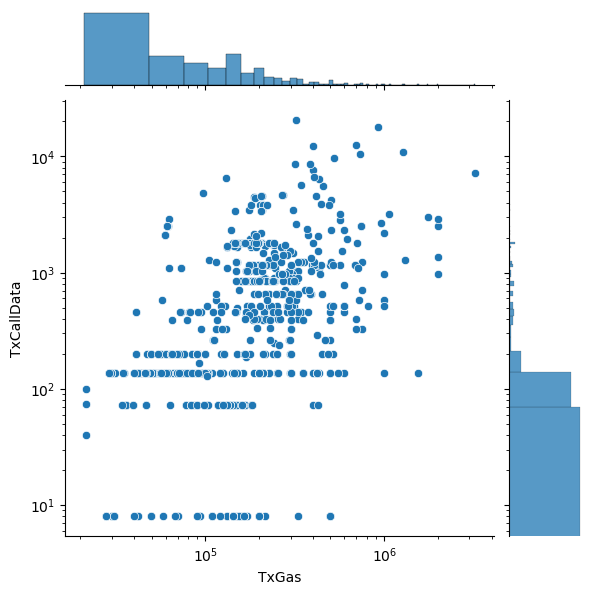

In [556]:
#####  This block cleans the data and plots call data vs gas  #####

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression
import seaborn as sns

data=pd.read_csv('TxF22.csv')
TxGas=list(data['gas']) #change to gas_used for old data from last year
TxCallData=list(data['input'])
TxCallData=[len(x[2:]) for x in TxCallData] #length of calldata after '0x' string for each entry

#upperLimit=500000 #drop extreme high Tx values
lowerLimitGas=21000 #drop extreme low Tx values
#print(round(100*(1-np.size([x for x in TxGas if x <= upperLimit])/np.size(TxGas)),3), '% of dataset dropped when truncating gas used over upper limit of',upperLimit )
proportionGasLowerLimit=(np.size([x for x in TxGas if x == lowerLimitGas])/np.size(TxGas))
print(round(100*proportionGasLowerLimit,3), '% of dataset dropped when truncating gas used equal to lower limit of',lowerLimitGas )
#lowerLimitCallData=0
#proportionCallDataLowerLimit=np.size([x for x in TxCallData if x == lowerLimitCallData])/np.size(TxCallData)
#print(round(100*proportionCallDataLowerLimit,3), '% of dataset dropped when truncating call data used equal to',lowerLimitCallData )

#Now randomly sample x and 1-x % of Tx to create test and training sets
np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 
df=pd.DataFrame({'TxGas':TxGas,'TxCallData':TxCallData})
#dfDropZeroCallData = df[df.TxCallData != 0]

#fig, ax = plt.subplots()
#ax.scatter(dfDropZeroCallData['TxGas'],dfDropZeroCallData['TxCallData'])
#ax.scatter(TxGas,TxCallData)
#####model = LinearRegression().fit(np.array(list(dfDropZeroCallData['TxGas'])).reshape((-1, 1)),list(dfDropZeroCallData['TxCallData']))
####ax.annotate('R-sq =' + str(round(model.score( np.array(list(dfDropZeroCallData['TxGas'])),list(dfDropZeroCallData['TxCallData'])   ),3)) ,xycoords='axes fraction',ha='right',va="center",fontsize=10)
#plt.xlabel('Transaction Gas Value', fontsize=16)
#plt.ylabel('Transaction Call Data Length', fontsize=16)
#ax.set_xscale('log')
#ax.set_yscale('log')
#plt.show()

jp=sns.jointplot(data=df, x="TxGas", y="TxCallData");
jp.ax_joint.set_xscale('log')
jp.ax_joint.set_yscale('log')

#TxGas=[x for x in TxGas if x <= upperLimit] #drop all over limit
TxGas=[x for x in TxGas if x != lowerLimitGas] #drop all equal to lower limit

#TxCallData=[x for x in TxCallData if x != 0] #drop all call data equal to 0

testSize=20 # % of Txs that will make up test set
TxGasTest=TxGas[0:round(len(TxGas)*testSize/100)]
TxGasTrain=TxGas[round(len(TxGas)*testSize/100):]

TxCallDataTest=TxCallData[0:round(len(TxCallData)*testSize/100)]
TxCallDataTrain=TxCallData[round(len(TxCallData)*testSize/100):]

#display(TxCallData)



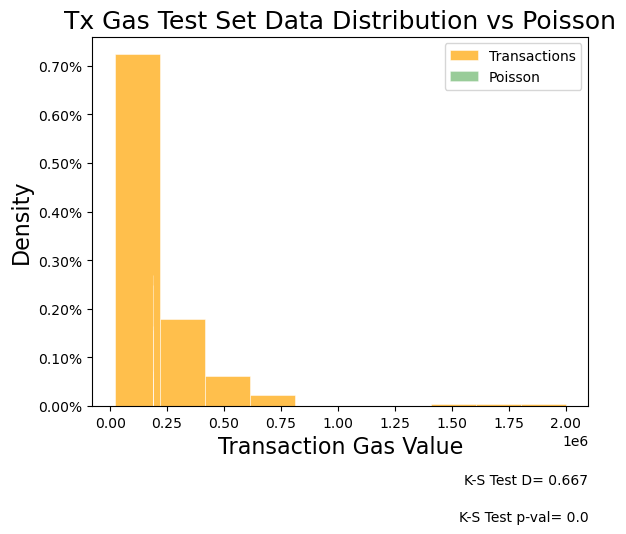

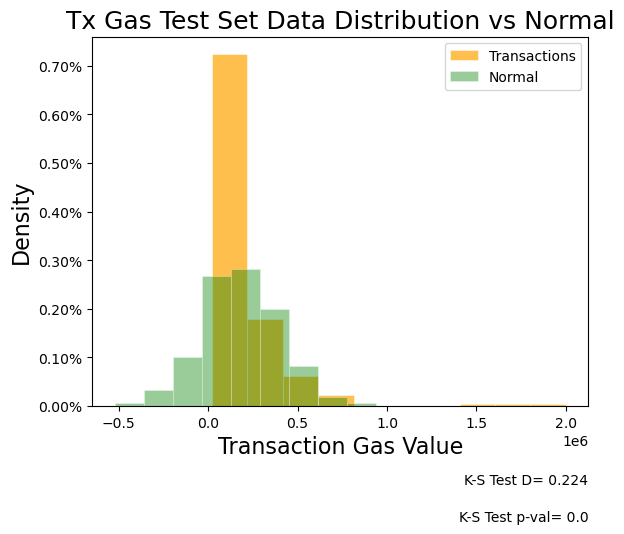

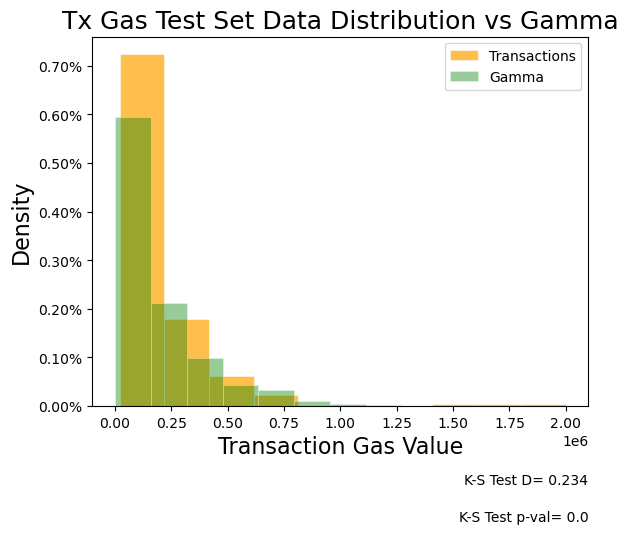

In [557]:
#####  This block fits gas to poisson/normal/gamma, runs K-S tests, and plots histograms  #####



#Tx=poisson(10,200000) #np.array([0,1,1.4,2,4,1,2,4,1,3,6,2,3,6,1,5])


numRVs=np.size(TxGasTrain)
poissGas=stats.poisson.rvs(np.mean(TxGasTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norGas=np.random.normal(np.mean(TxGasTrain),np.var(TxGasTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aGas=(np.mean(TxGasTrain))**2/np.var(TxGasTrain)
betaGas=(np.mean(TxGasTrain))/np.var(TxGasTrain)
gamGas=stats.gamma.rvs(aGas, scale=1/betaGas,size=numRVs)




fig, ax = plt.subplots()
binNumTxGas=1000
binNumDistr=100
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxGasTest,alpha=0.7,label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxGasTest)) / len(TxGasTest) )
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Gas Test Set Data Distribution vs Poisson', fontsize=18)
#ax.set_xscale('log')
ax.hist(poissGas,label='Poisson', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(poissGas)) / len(poissGas) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxGasTest, poissGas)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxGasTest, poissGas)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxGasTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxGasTest)) / len(TxGasTest) )
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Gas Test Set Data Distribution vs Normal', fontsize=18)
#ax.set_xscale('log')
ax.hist(norGas,label='Normal', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(norGas)) / len(norGas) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxGasTest, norGas)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxGasTest, norGas)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
#fig.tight_layout()
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxGasTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxGasTest)) / len(TxGasTest) )
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Gas Test Set Data Distribution vs Gamma', fontsize=18)
#ax.set_xscale('log')
ax.hist(gamGas,label='Gamma', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(gamGas)) / len(gamGas) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxGasTest, gamGas)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxGasTest, gamGas)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()



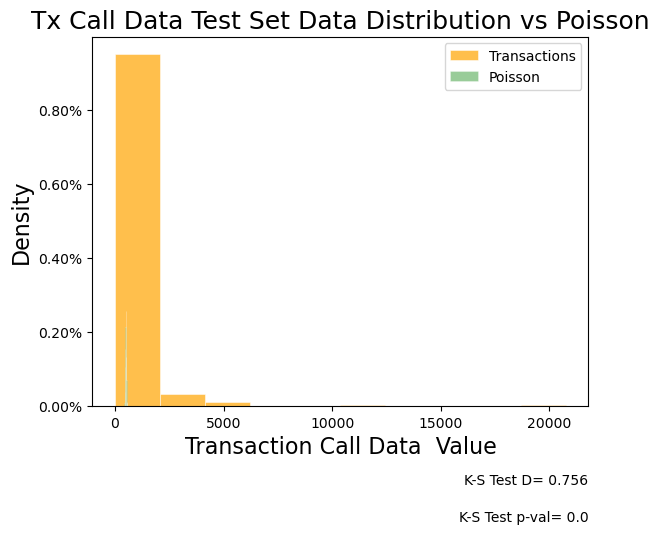

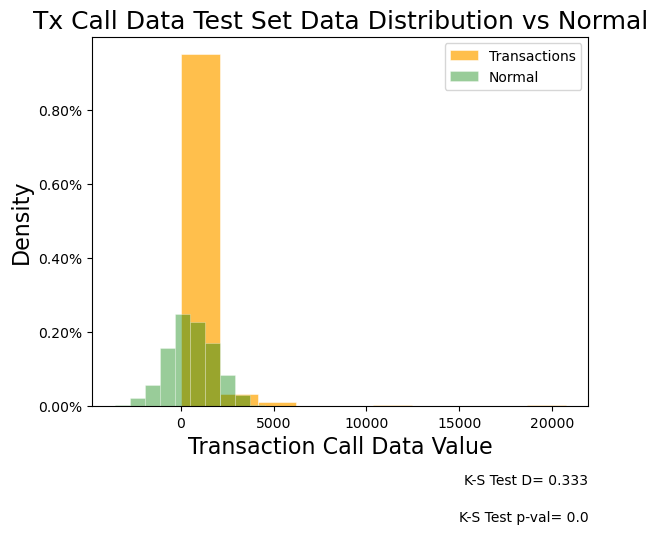

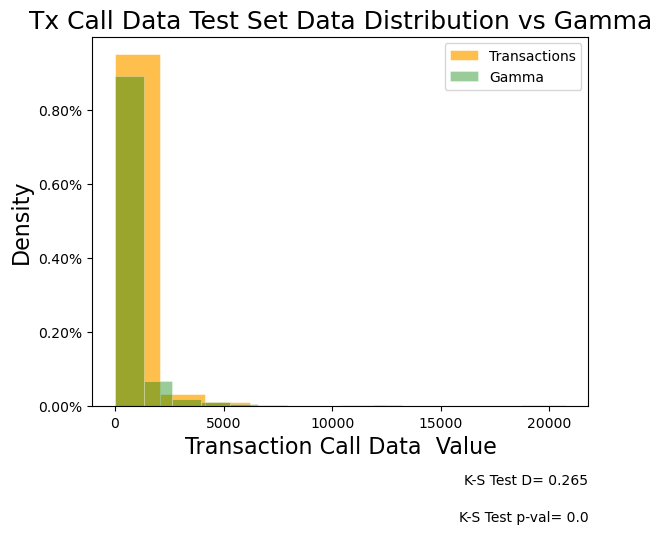

In [558]:
#####  This block fits call data to poisson/normal/gamma, runs K-S tests, and plots histograms  #####

numRVs=np.size(TxCallDataTrain)
poissCallData=stats.poisson.rvs(np.mean(TxCallDataTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norCallData=np.random.normal(np.mean(TxCallDataTrain),np.var(TxCallDataTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aCallData=(np.mean(TxCallDataTrain))**2/np.var(TxCallDataTrain)
betaCallData=(np.mean(TxCallDataTrain))/np.var(TxCallDataTrain)
gamCallData=stats.gamma.rvs(aCallData, scale=1/betaCallData,size=numRVs)




fig, ax = plt.subplots()
binNumTxCallData=1000
binNumDistr=100
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7,label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data  Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Poisson', fontsize=18)
#ax.set_xscale('log')
ax.hist(poissCallData,label='Poisson', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(poissCallData)) / len(poissCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, poissCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, poissCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Normal', fontsize=18)
#ax.set_xscale('log')
ax.hist(norCallData,label='Normal', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(norCallData)) / len(norCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, norCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, norCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
#fig.tight_layout()
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data  Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Gamma', fontsize=18)
#ax.set_xscale('log')
ax.hist(gamCallData,label='Gamma', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(gamCallData)) / len(gamCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, gamCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, gamCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()



In [559]:
#####  This block generates gas and call data from separate gamma distributions  #####


#Now generate from Tx-gamma:
lenGenerated=10
TxGasGenerated=[]
TxCallDataGenerated=[]
for i in range(lenGenerated):
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1))) #must change to break into if statement below to generate diff calldata distr when gas=21k           
    ran=random.uniform(0, 1)
    #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
    if ran<proportionGasLowerLimit:
        TxGasGenerated.append(lowerLimitGas)
    else: 
        TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    #if ran2<proportionCallDataLowerLimit:
    #    TxCallDataGenerated.append(lowerLimitCallData)
    #else: 
    #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    
print(TxGasGenerated)
print(TxCallDataGenerated)




[16234.484719634494, 305017.12517282687, 385288.05930868495, 2112.6675360141357, 797432.7714563236, 722511.8348279583, 180089.08347923882, 21000, 151512.42177768057, 56877.37902449343]
[21.37859344148805, 189.46213289863186, 1.656880259357346, 18.74119957651963, 458.80207355483776, 0.2431322311726857, 1.1153331564131426e-07, 64.84681652523473, 8.784635705449642, 971.4256598213551]


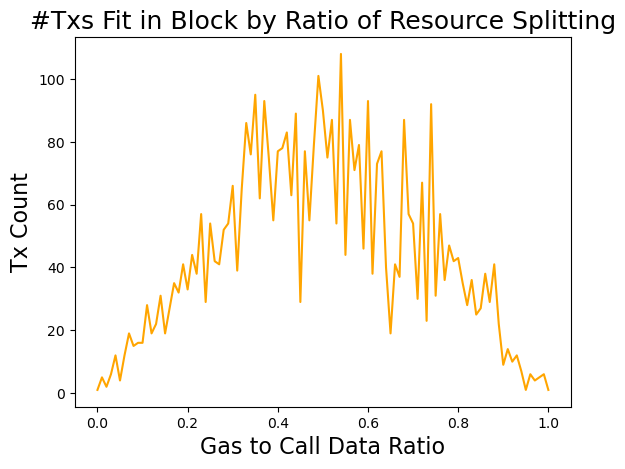

In [560]:
#####  This block generates gas and call data from separate gamma distributions  but now optimize for ratio to see how many Txs fit in total  #####

TxCount=[]
rangeGasRatio=np.linspace(0,1,101)
for i in rangeGasRatio:
    gasMEIPRatio=i #run simulation from 0 to 1 to optimize # Txs per block? or some other metric?
    callDataMEIPRatio=1-gasMEIPRatio
    currentGasLimit=30e6
    mEIPGasLimit=currentGasLimit*gasMEIPRatio #estimate the use of gas to be 2/3 of what calldata will be. How to improve this estimate?
    currentAvgTxPerBlock=round(currentGasLimit/np.mean(TxGasTrain)) #how many Tx we can fit into 30mil gas block
    mEIPCallDataLimit=round(callDataMEIPRatio*currentAvgTxPerBlock*np.mean(TxCallDataTrain)) #how much call data we can fit into block scaled by ratio of current CD to gas 

    TxGasGenerated=[]
    TxCallDataGenerated=[]
    while np.sum(TxGasGenerated)<=mEIPGasLimit and np.sum(TxCallDataGenerated)<=mEIPCallDataLimit:
        TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1)))
        ran=random.uniform(0, 1)
        #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
        if ran<proportionGasLowerLimit:
            TxGasGenerated.append(lowerLimitGas)
        else: 
            TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
        #if ran2<proportionCallDataLowerLimit:
        #    TxCallDataGenerated.append(lowerLimitCallData)
        #else: 
        #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    TxCount.append(len(TxGasGenerated))


fig, ax = plt.subplots()
ax.plot(rangeGasRatio,TxCount, color='orange')
plt.xlabel('Gas to Call Data Ratio', fontsize=16)
plt.ylabel('Tx Count', fontsize=16)
plt.title('#Txs Fit in Block by Ratio of Resource Splitting', fontsize=18)
plt.show()





In [561]:
gasMEIPRatio=.5 #run simulation from 0 to 1 to optimize # Txs per block? or some other metric?
callDataMEIPRatio=1-gasMEIPRatio
currentGasLimit=30e6
mEIPGasLimit=currentGasLimit*gasMEIPRatio # How to improve this estimate?
currentAvgTxPerBlock=round(currentGasLimit/np.mean(TxGasTrain)) #how many Tx we can fit into 30mil gas block
mEIPCallDataLimit=round(callDataMEIPRatio*currentAvgTxPerBlock*np.mean(TxCallDataTrain)) #how much call data we can fit into block scaled by ratio of current CD to gas 

TxGasGenerated=[]
TxCallDataGenerated=[]
while np.sum(TxGasGenerated)<=mEIPGasLimit and np.sum(TxCallDataGenerated)<=mEIPCallDataLimit:
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1)))
    ran=random.uniform(0, 1)
    #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
    if ran<proportionGasLowerLimit:
        TxGasGenerated.append(lowerLimitGas)
    else: 
        TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    #if ran2<proportionCallDataLowerLimit:
    #    TxCallDataGenerated.append(lowerLimitCallData)
    #else: 
    #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
print(TxCallDataGenerated)
print(TxGasGenerated)
print(len(TxCallDataGenerated))

[0.06069886083049469, 0.0003756796728290533, 345.77494239610155, 4962.801748494011, 12.249849820102039, 36.66857348714388, 0.043797922454563924, 0.022325146448315243, 0.3410485609308558, 1.3162387874557704, 0.04164765312212971, 213.1035000901944, 2.5527996700017637, 905.5174993700851, 3.5088489081956817e-06, 1074.7115200068372, 87.91830415371838, 0.02227962770856128, 677.2810663453332, 1.1257244514581535e-08, 0.007817026892746333, 0.1986076535117173, 301.57600756703687, 0.008620407315880822, 84.27839659530743, 0.012091529278353837, 24.63793906006071, 4.529183887031731e-09, 51.15568804569632, 0.041756996591736456, 46.18656008725045, 46.42976512058168, 359.6652752558549, 48.22111107982439, 38.61764068240301, 8.502530587640896, 83.87494320522825, 2.241242064202237, 0.0017005255540733196, 7449.338814160312, 481.25987047659265, 7.571194755697179e-07, 86.02310703771728, 65.55084767071193, 1146.910695846122, 6.044101671208103e-08, 1525.5063208780775, 24.7238517228945, 1.4537793775624264, 253.

In [562]:

#NEXT STEPS: 
#partition 21000 Txs and refit, avoid overfitting with gamma - test/training sets 
        #completed in block 1
#pick best rn bronze standard gamma is good enough now and hten some small work on gamma gamma - sample beta from diff users.
    #put whole story into the hackmd- with the 21000 then without then show how bad poisson and normal are and 
    #then show charts of how good the gmama does
    #include neagtive results too 
        #completed


#barnabe- in the case we aplit gas, we mY and Z are hard to explain but they are probably very correlated. 
#might not need x and y to = z
#longer term:        ppl using rollups are ok with waiting, execution is to go fast
#meip only reduced congestion if strong anticorrelation betwene 2 resources




#joint distribution. actually we do see like 5 clusters. what are their significance? diff call data lengths. am i accidentally using gas limit? not gas used?


######Similar to the high proportion of gas used falling at the lower limit of 21000, we see 23.0% of call data strings with a length of zero. Omitting these,  are we able to improve upon our models.
        #completed - omitting 0 calldata =worse
    
# dont draw from 2 distributions of callData/gas. draw from joint. how to model joint? copula? Cant assume marginals independent
#given 21k gas, genereate CD, rest independence




In [627]:
#toy code:





ssss=0
ratioBreaks=[]
for i in list(mostCommonDf['Ratio of Dataset']):
    ratioBreaks.append(i+np.sum(list(mostCommonDf['Ratio of Dataset'])[0:ssss]))
    ssss=ssss+1
ratioBreaks.append(1)
ratioBreaks.insert(0,0)



print(ratioBreaks)

lenGenerated=10
TxGasGenerated=[]
TxCallDataGenerated=[]
for i in range(lenGenerated):
    ran=random.uniform(0, 1)
    print(ran)
    for j in range(len(ratioBreaks)-1): #maybe  do -2 bc else could lead to bulk generation
        if ran >= ratioBreaks[j] and ran <= ratioBreaks[j+1]: 
            print(ratioBreaks[j])
            print(ratioBreaks[j+1])
            print(ran)
        #else: #generate from bulk 

            print(list(mostCommonDf['Gas Value'])[j-1]) #needs to be in if bc the last ratio range should be  dfBulk
            print(' ')
            #TxGasGenerated.append(lowerLimitGas)
        else: 
            TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))


[0, 0.431, 0.29, 0.271, 1]
0.38203229515046044
0
0.431
0.38203229515046044
109508
 
0.271
1
0.38203229515046044
109508
 
0.7602448267592414
0.271
1
0.7602448267592414
109508
 
0.3185766106199929
0
0.431
0.3185766106199929
109508
 
0.271
1
0.3185766106199929
109508
 
0.721330270234675
0.271
1
0.721330270234675
109508
 
0.39713980934842397
0
0.431
0.39713980934842397
109508
 
0.271
1
0.39713980934842397
109508
 
0.019396837662008504
0
0.431
0.019396837662008504
109508
 
0.46258579040203196
0.271
1
0.46258579040203196
109508
 
0.06811285144441692
0
0.431
0.06811285144441692
109508
 
0.7847167270756267
0.271
1
0.7847167270756267
109508
 
0.845037342056756
0.271
1
0.845037342056756
109508
 


   for the gas value of  21000 the CallData lengths take on 1 values
     for the gas value of  21000 the CallData of length 0 was observed in  18.3% of the dataset

 for the gas value of  21000 the CallData of length 0 was observed in  18.3% of the dataset

   for the gas value of  109508 the CallData lengths take on 1 values
     for the gas value of  109508 the CallData of length 8 was observed in  2.3% of the dataset

 for the gas value of  109508 the CallData of length 8 was observed in  2.3% of the dataset

   for the gas value of  142361 the CallData lengths take on 1 values
     for the gas value of  142361 the CallData of length 8 was observed in  4.2% of the dataset

 for the gas value of  142361 the CallData of length 8 was observed in  4.2% of the dataset

   for the gas value of  90000 the CallData lengths take on 5 values

 for the gas value of  90000 the CallData of length 136 was observed in  2.3% of the dataset



,Gas Value,Call Data Length,Ratio of Dataset,# times in set
0,21000,0,0.183,1
1,21000,0,0.183,1
2,109508,8,0.023,1
3,109508,8,0.023,1
4,142361,8,0.042,1
5,142361,8,0.042,1
6,90000,136,0.023,1


   for the CallData of length  0 the Gas takes on  29 values
     for the CallData of length  0 the Gas value 21000 was observed in  18.3% of the dataset
   for the CallData of length  8 the Gas takes on  27 values
     for the CallData of length  8 the Gas value 109508 was observed in  2.3% of the dataset
     for the CallData of length  8 the Gas value 142361 was observed in  4.2% of the dataset
   for the CallData of length  1800 the Gas takes on  28 values
   for the CallData of length  200 the Gas takes on  46 values
   for the CallData of length  136 the Gas takes on  195 values
   for the CallData of length  840 the Gas takes on  31 values
   for the CallData of length  456 the Gas takes on  27 values
   for the CallData of length  72 the Gas takes on  38 values


,Gas Value,Call Data Length,Ratio of Dataset,# times in set
0,21000,0,0.183,29
1,109508,8,0.023,27
2,142361,8,0.042,27


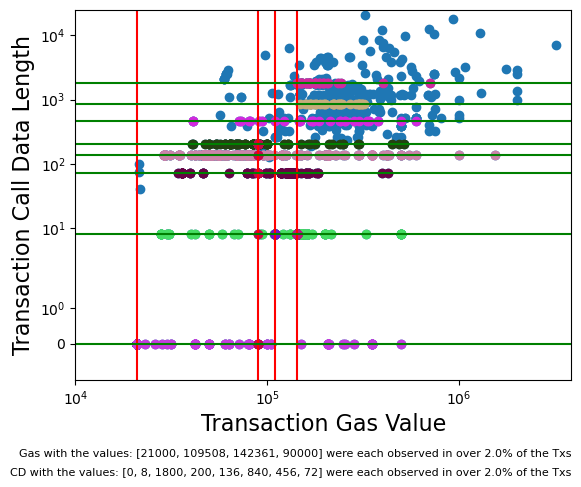

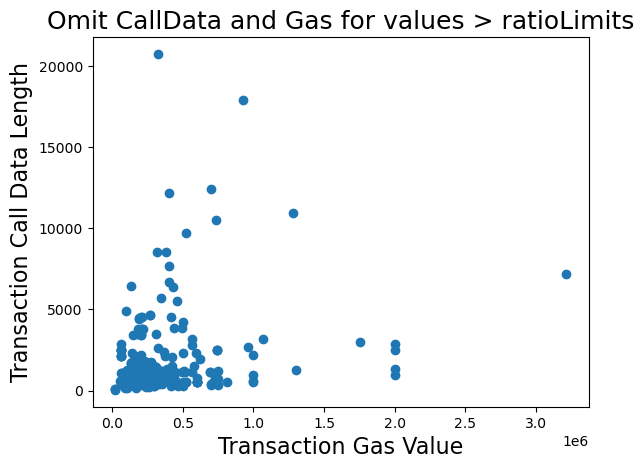

[134679.32475125007, 21000, 227689.5334807389, 87734.42758560904, 781570.9607006229, 21000, 291551.80029899307, 21000, 46247.41987258258, 240604.8660627155, 445357.97229953913, 442719.5335552046, 74383.14763216692, 50020.75543683517, 21000, 1279.7152095818024, 575099.542461408, 949941.0525513218, 163623.5490005499, 551453.818545898, 514518.68795274245, 21000, 206520.0789752626, 768571.8207351029, 21000, 408013.2823410147, 52062.54810094791, 145964.50473375004, 86738.95085181839, 151412.6514674036, 514134.0784579642, 436610.9413088152, 466169.441160116, 21000, 21000, 1228972.9926169214, 19623.73595831548, 260937.05901387442, 646578.3607478761, 613511.4340062028, 147837.83068665705, 210817.84649817972, 288343.9173078439, 21000, 361001.93469004537, 21000, 21000, 118309.91525629559, 140875.2927656172, 1811481.1755484878, 21000, 100937.47966856047, 504672.3095670185, 5975.979949718396, 55751.340314424226, 506.8202872479712, 204589.73806002334, 22583.51775103592, 555441.8263857382, 375519.28

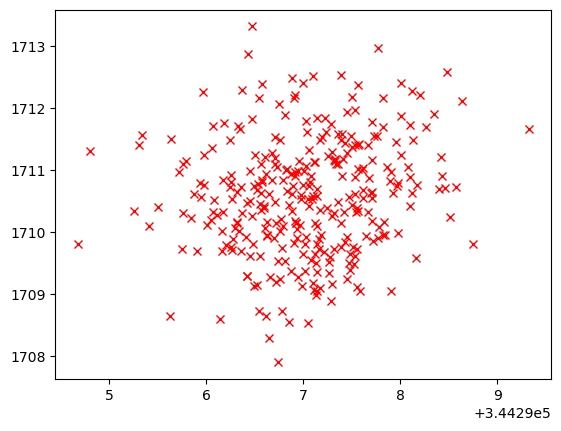

In [621]:
 #   for gasVal=90000 , gasValCount=32,     the ratio is >2% so add to commonGas list that goes into plot vert line
    # then loop thru the call data values for 90k. 136, 200, 0, 72, and 8 (CallDataLen values in loop#2). 
    #need to isolate any CallDataLen that have count (CallDataLenCount) ratios > limit and include them in a model 
    #that generates them. For example, if gas 90k has lots of callData at len 200, then generate those at the %
    #they appear in the dataset. then check if the other callData lengths 
#still     
    
#Find most common Gas
ratioLimitGas=0.02
commonGas=[]
topGasList=[]
for gasVal,gasValCount in (dict(Counter(df.TxGas)).items()): 
    if gasValCount/len(df) > ratioLimitGas: #if gas value is present in high proportion of dataset
        s=0
        print('   for the gas value of  '+ str(gasVal) + ' the CallData lengths take on '+str(len(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[:]))+ ' values')
        commonGas.append(gasVal)
        for CallDataLen,CallDataLenCount in dict(Counter(list(df[df.TxGas==gasVal].TxCallData))).items():
            #if the gas value in question is split into more than 1 CallData length
            if CallDataLenCount/len(TxCallData) > ratioLimitGas: 
                print('     for the gas value of  '+ str(gasVal) + ' the CallData of length '+ str(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[s]) + ' was observed in  ' +str(round(100*CallDataLenCount/len(df),1)) + '% of the dataset')
                topGasList.append((gasVal,list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[s],round(CallDataLenCount/len(df),3),len(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[:])))
                s=s+1
        print('')
        print(' for the gas value of  '+ str(gasVal) + ' the CallData of length '+ str(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[0]) + ' was observed in  ' +str(round(100*gasValCount/len(df),1)) + '% of the dataset')
        print('')
        topGasList.append((gasVal,list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[0],round(gasValCount/len(df),3),1))

commonDf=pd.DataFrame(topGasList,columns=['Gas Value','Call Data Length','Ratio of Dataset','# times in set'])
display(commonDf)



#Find most common CallData

ratioLimitCallData=0.02
commonCallData=[]
topCallDataList=[]
for k,v in (dict(Counter(df.TxCallData)).items()):
    if v/len(df) > ratioLimitCallData:
        if len(list(Counter(list(df[df['TxCallData']==k].TxGas)).keys())[:])>1: 
            s=0
            print('   for the CallData of length  '+ str(k) + ' the Gas takes on  '+str(len(list(Counter(list(df[df['TxCallData']==k].TxGas)).keys())[:]))+ ' values')
            commonCallData.append(k)
            for kk,vv in dict(Counter(list(df[df['TxCallData']==k].TxGas))).items():
                #if the gas value in question is split into more than 1 CallData length
                if vv/len(TxCallData) > ratioLimitCallData: 
                    topCallDataList.append((kk,k,round(vv/len(df),3),len(list(Counter(list(df[df['TxCallData']==k].TxGas)).keys())[:])))
                    print('     for the CallData of length  '+ str(k) + ' the Gas value '+ str(kk) + ' was observed in  ' +str(round(100*vv/len(df),1)) + '% of the dataset')
                    s=s+1
        else:
            print('')
            print(' for the CallData of length  '+ str(k) + ' the Gas value '+ str(list(Counter(list(df[df['TxCallData']==k].TxGas)).keys())[0]) + ' was observed in  ' +str(round(100*v/len(df),1)) + '% of the dataset')
            print('')
            commonCallData.append(k)
            topCallDataList.append((list(Counter(list(df[df['TxCallData']==k].TxGas)).keys())[0],k,round(v/len(df),3),1))
mostCommonDf=(pd.DataFrame(topCallDataList,columns=['Gas Value','Call Data Length','Ratio of Dataset','# times in set']))
display(mostCommonDf)

fig, ax = plt.subplots()
ax.scatter(df['TxGas'],df['TxCallData'])
ax.set_xscale('symlog')
ax.set_yscale('symlog')

from random import randint
colors = []
for i in range(len(commonCallData)):
    random.seed(i*22)
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
ss=0
dfBulk=df
for i in commonCallData:
    dfBulk=dfBulk[dfBulk.TxCallData != i]
    ax.scatter(df[df['TxCallData']==i].TxGas,df[df['TxCallData']==i].TxCallData,color=colors[ss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ss=ss+1

colors2 = []   
for i in range(len(commonGas)):
    random.seed(i*8)
    colors2.append('#%06X' % randint(0, 0xFFFFFF))

sss=0
for i in commonGas:
    dfBulk=dfBulk[dfBulk.TxGas != i]
    ax.scatter(df[df['TxGas']==i].TxGas,df[df['TxGas']==i].TxCallData,color=colors2[sss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    sss=sss+1
    
for i in range(len(commonGas)):
    plt.axvline(x=commonGas[i],color='r')    
for i in range(len(commonCallData)):
    plt.axhline(y=commonCallData[i],color='g')    

ax.annotate('Gas with the values: '+str(commonGas)+' were each observed in over '+str(100*ratioLimitGas)+'% of the Txs',xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=8)
ax.annotate('CD with the values: '+str(commonCallData)+' were each observed in over '+str(100*ratioLimitCallData)+'% of the Txs',xy = (1, -0.25),xycoords='axes fraction',ha='right',va="center",fontsize=8)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Call Data Length', fontsize=16)
plt.xlim([1e4, np.max(df.TxGas)*1.2])
plt.ylim([-1, np.max(df.TxCallData)*1.2])

plt.show()


fig, ax = plt.subplots()
ax.scatter(dfBulk['TxGas'],dfBulk['TxCallData'])
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
plt.title('Omit CallData and Gas for values > ratioLimits', fontsize=18)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Call Data Length', fontsize=16)
plt.show()


#Try to model the bulk of the data
logCovMat=np.cov(np.log(dfBulk['TxGas']),np.log(dfBulk['TxCallData']))
logMuGas=(np.mean(dfBulk['TxGas']))
logMuCallData=(np.mean(dfBulk['TxCallData']))

x, y = np.random.multivariate_normal([logMuGas,logMuCallData], logCovMat, len(dfBulk['TxGas'])).T
plt.plot(x, y, 'x',color='r')




#Now generate from Tx-gamma:

#bulk of data gamma:

dfBulkTrain=dfBulk.sample(frac=.8, random_state=200)
dfBulkTest=dfBulk.drop(dfBulkTrain.index)


aCallData=(np.mean(dfBulkTrain.TxCallData))**2/np.var(dfBulkTrain.TxCallData)
betaCallData=(np.mean(dfBulkTrain.TxCallData))/np.var(dfBulkTrain.TxCallData)

aGas=(np.mean(dfBulkTrain.TxGas))**2/np.var(dfBulkTrain.TxGas)
betaGas=(np.mean(dfBulkTrain.TxGas))/np.var(dfBulkTrain.TxGas)


mostCommonDf=mostCommonDf.sort_values(by=['Ratio of Dataset'],ascending=False)
ssss=0
ratioBreaks=[]
for i in list(mostCommonDf['Ratio of Dataset']):
    ratioBreaks.append(i+np.sum(list(mostCommonDf['Ratio of Dataset'])[0:ssss]))
    ssss=ssss+1
ratioBreaks.append(1)
ratioBreaks.insert(0,0)


lenGenerated=100
TxGasGenerated=[]
TxCallDataGenerated=[]
for i in range(lenGenerated):
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1))) #must change to break into if statement below to generate diff calldata distr when gas=21k           
    ran=random.uniform(0, 1)
    if ran<proportionGasLowerLimit: #CHANGE TO MAKE RANGE THAT WILL GENERATE FROM # OF COMMON
        TxGasGenerated.append(lowerLimitGas)
    else: 
        TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    
print(TxGasGenerated)
print(TxCallDataGenerated)





In [590]:
for k,v in (dict(Counter(df.TxGas)).items()): #k is gas, v is count
    if v/len(df) > ratioLimitGas: #if gas value is present in high proportion of dataset
        s=0
        print('   for the gas value of  '+ str(k) + ' the CallData lengths take on '+str(len(list(Counter(list(df[df['TxGas']==k].TxCallData)).keys())[:]))+ ' values')
        for kk,vv in dict(Counter(list(df[df['TxGas']==k].TxCallData))).items():
            if vv/len(TxCallData) > ratioLimitGas: 
                print((k,list(Counter(list(df[df['TxGas']==k].TxCallData)).keys())[s],round(vv/len(df),3),len(list(Counter(list(df[df['TxGas']==k].TxCallData)).keys())[:])))
                s=s+1


   for the gas value of  21000 the CallData lengths take on 1 values
(21000, 0, 0.183, 1)
   for the gas value of  109508 the CallData lengths take on 1 values
(109508, 8, 0.023, 1)
   for the gas value of  350000 the CallData lengths take on 3 values
(350000, 136, 0.011, 3)
   for the gas value of  142361 the CallData lengths take on 1 values
(142361, 8, 0.042, 1)
   for the gas value of  500000 the CallData lengths take on 7 values
   for the gas value of  90000 the CallData lengths take on 5 values
(90000, 136, 0.014, 5)
   for the gas value of  142360 the CallData lengths take on 1 values
(142360, 8, 0.016, 1)
   for the gas value of  207128 the CallData lengths take on 2 values
   for the gas value of  132663 the CallData lengths take on 1 values
(132663, 72, 0.016, 1)


In [622]:
dict(Counter(list(df[df.TxGas==90000].TxCallData))).items()    


dict_items([(136, 3), (200, 20), (0, 5), (72, 3), (8, 1)])

In [625]:
df[df.TxGas==90000]

,TxGas,TxCallData
24,90000,136
44,90000,200
50,90000,200
81,90000,0
98,90000,200
127,90000,72
222,90000,200
240,90000,200
288,90000,200
381,90000,72
